# STL-10: Supervised vs PI-model (Semi-Supervised) with a SimCLR encoder

This notebook runs:

1. PI-model with 4500 labeled
2. Supervised with 1000 labeled
3. PI-model with 1000 labeled

All experiments use:
- STL-10 labeled train split (5000) split into 4500 train / 500 val with stratification
- STL-10 unlabeled split (100k) for PI-model consistency loss



In [ ]:

import os, math, time, random
from dataclasses import dataclass
from pathlib import Path
from itertools import cycle

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, Subset

from torchvision.datasets import STL10
from torchvision import models

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [ ]:
def get_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

SEED = 42
get_seed(SEED)


In [ ]:

@dataclass
class CFG:
    data_root: str = "./data"

    # epochs
    epochs_pi_4500: int = 20
    epochs_sup_1000: int = 30
    epochs_pi_1000: int = 30

    lr_head: float = 1e-3

    # pi-model unsupervised loss
    pi_max_w: float = 30.0

    # Model
    num_classes: int = 10
    projection_dim: int = 128

    # SimCLR pretrained weights
    simclr_ckpt_path: str = "./simclr_pretrained.pth"

cfg = CFG()
cfg


CFG(data_root='./data', epochs_pi_4500=20, epochs_sup_1000=30, epochs_pi_1000=30, lr_head=0.001, pi_max_w=30.0, num_classes=10, projection_dim=128, simclr_ckpt_path='./simclr_pretrained.pth')

In [ ]:

IM_MEAN = (0.485, 0.456, 0.406)
IM_STD  = (0.229, 0.224, 0.225)

train_transform = T.Compose([
    T.RandomResizedCrop(96, scale=(0.8, 1.0), antialias=True),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    T.Normalize(IM_MEAN, IM_STD),
])


test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(IM_MEAN, IM_STD),
])




In [ ]:

class PiModelDataset(Dataset):
    """Returns two stochastic views and the label"""
    def __init__(self, base_dataset, transform):
        self.dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, y = self.dataset[index]  # PIL image
        x1 = self.transform(img)
        x2 = self.transform(img)
        return x1, x2, y

class SingleViewSubset(Dataset):
    """Applies a transform to a Subset of a base dataset with transform=None."""
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, i):
        img, y = self.subset[i]  # PIL image
        x = self.transform(img)
        return x, y


In [ ]:
Path(cfg.data_root).mkdir(parents=True, exist_ok=True)

labeled_train_full = STL10(root=cfg.data_root, split="train", download=True, transform=None)      # 5000
unlabeled_base     = STL10(root=cfg.data_root, split="unlabeled", download=True, transform=None)  # 100,000
test_ds          = STL10(root=cfg.data_root, split="test", download=True, transform=test_transform)       # 8000

y_full = np.array(labeled_train_full.labels)
num_classes = int(y_full.max() + 1)

print("labeled train length:", len(labeled_train_full))
print("unlabeled length:", len(unlabeled_base))
print("test:", len(test_ds))
print("train class counts:", np.bincount(y_full, minlength=num_classes))


100%|██████████| 2.64G/2.64G [06:07<00:00, 7.19MB/s]


labeled train length: 5000
unlabeled length: 100000
test: 8000
train class counts: [500 500 500 500 500 500 500 500 500 500]


In [ ]:
import pandas as pd
# Stratified split: 4500 train, 500 val
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED)
X_dummy = np.zeros((len(y_full), 1))
train_idx_4500, val_idx_500 = next(sss.split(X_dummy, y_full))

train_idx_4500 = np.array(train_idx_4500)
val_idx_500 = np.array(val_idx_500)

print("train labeled (4500):", len(train_idx_4500))
print("val labeled (500):", len(val_idx_500))

print("4500 train counts:")
print(pd.Series(y_full[train_idx_4500]).value_counts().sort_index())
print("val counts:")
print(pd.Series(y_full[val_idx_500]).value_counts().sort_index())

train labeled (4500): 4500
val labeled (500): 500
4500 train counts:
0    450
1    450
2    450
3    450
4    450
5    450
6    450
7    450
8    450
9    450
Name: count, dtype: int64
val counts:
0    50
1    50
2    50
3    50
4    50
5    50
6    50
7    50
8    50
9    50
Name: count, dtype: int64


In [ ]:
# Stratified sub-sampling to 1000 labeled from the 4500 pool
# same val set
y_pool = y_full[train_idx_4500]

sss_1k = StratifiedShuffleSplit(n_splits=1, train_size=1000, random_state=SEED)
idx_1k_local, _ = next(sss_1k.split(np.zeros((len(y_pool), 1)), y_pool))

train_idx_1000 = train_idx_4500[idx_1k_local]

print("train labeled (1000):", len(train_idx_1000))
print("1000 train counts:")
print(pd.Series(y_full[train_idx_1000]).value_counts().sort_index)


train labeled (1000): 1000
1000 train counts:
<bound method Series.sort_index of 8    100
1    100
3    100
2    100
9    100
4    100
6    100
7    100
0    100
5    100
Name: count, dtype: int64>


In [ ]:
# Base subsets
train_base_4500 = Subset(labeled_train_full, train_idx_4500.tolist())
train_base_1000 = Subset(labeled_train_full, train_idx_1000.tolist())
val_base_500     = Subset(labeled_train_full, val_idx_500.tolist())

# Datasets
pi_train_4500 = PiModelDataset(train_base_4500, train_transform)
pi_train_1000 = PiModelDataset(train_base_1000, train_transform)
unlabeled_ds  = PiModelDataset(unlabeled_base, train_transform)

sup_train_1000 = SingleViewSubset(train_base_1000, train_transform)
val_ds         = SingleViewSubset(val_base_500, test_transform)

sup_train_4500 = SingleViewSubset(train_base_4500, train_transform)
sup_loader_4500 = DataLoader(sup_train_4500, batch_size=256, shuffle=True, drop_last=True)


# Loaders
labeled_loader_pi_4500 = DataLoader(pi_train_4500, batch_size=256, shuffle=True, drop_last=True)
labeled_loader_pi_1000 = DataLoader(pi_train_1000, batch_size=256, shuffle=True, drop_last=True)
unlabeled_loader = DataLoader(unlabeled_ds,  batch_size=256, shuffle=True, drop_last=True)
sup_loader_1000 = DataLoader(sup_train_1000, batch_size=256, shuffle=True, drop_last=True)

val_loader  = DataLoader(val_ds,  batch_size=256, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)


# shapes
xb, yb = next(iter(sup_loader_1000))
x1, x2, y = next(iter(labeled_loader_pi_1000))
u1, u2, uy = next(iter(unlabeled_loader))

print("sup batch:", xb.shape, yb.shape, "labels min/max:", int(yb.min()), int(yb.max()))
print("PI labeled batch:", x1.shape, x2.shape, y.shape)
print("PI unlabeled batch:", u1.shape, u2.shape, uy.shape, "unique labels sample:", torch.unique(uy)[:5]) # y -1, no label
print("Mean |x1-x2|:", (x1 - x2).abs().mean().item())


sup batch: torch.Size([256, 3, 96, 96]) torch.Size([256]) labels min/max: 0 9
PI labeled batch: torch.Size([256, 3, 96, 96]) torch.Size([256, 3, 96, 96]) torch.Size([256])
PI unlabeled batch: torch.Size([256, 3, 96, 96]) torch.Size([256, 3, 96, 96]) torch.Size([256]) unique labels sample: tensor([-1])
Mean |x1-x2|: 0.6340590715408325


In [ ]:
# Model: SimCLR encoder loader + classifier head
from pathlib import Path
import torch
import torch.nn as nn
from torchvision import models

class SimCLREncoder(nn.Module):
    """ResNet-18 encoder with the final fc removed."""
    def __init__(self):
        super().__init__()
        base = models.resnet18(weights=None)
        feat_dim = base.fc.in_features
        base.fc = nn.Identity()
        self.encoder = base
        self.feat_dim = feat_dim

    def forward(self, x):
        return self.encoder(x)

class SimCLRModel(nn.Module):
    """SimCLR pretrain model: encoder + projection head"""
    def __init__(self, projection_dim=128):
        super().__init__()
        self.encoder = SimCLREncoder()
        d = self.encoder.feat_dim
        self.projection_head = nn.Sequential(
            nn.Linear(d, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projection_head(h)
        return z

class Classifier(nn.Module):
    def __init__(self, feat_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(feat_dim, num_classes)

    def forward(self, h):
        return self.fc(h)

class EncoderWithHead(nn.Module):
    def __init__(self, encoder: nn.Module, feat_dim: int, num_classes: int):
        super().__init__()
        self.encoder = encoder
        self.head = Classifier(feat_dim, num_classes)

    def forward(self, x):
        h = self.encoder(x)
        return self.head(h)

def load_simclr_encoder_weights(simclr_encoder: SimCLREncoder, ckpt_path: str, verbose_keys: int = 10) -> bool:
    """
    Loads ONLY the encoder weights saved under ckpt['simclr_state'] into simclr_encoder.encoder (ResNet).
    Expects checkpoint saved as: save_ckpt(..., simclr_state=simclr.state_dict(), ...)
    """
    ckpt_path = Path(ckpt_path)
    if not ckpt_path.exists():
        print(f"[ERR] Checkpoint not found: {ckpt_path.resolve()}")
        return False

    ckpt = torch.load(str(ckpt_path), map_location="cpu")
    if "simclr_state" not in ckpt:
        print(f"[ERR] 'simclr_state' key not found. Keys: {list(ckpt.keys())}")
        return False

    state = ckpt["simclr_state"]
    print("Checkpoint keys:", ckpt.keys())

    # show a few keys so you can confirm format
    print("\nFirst keys in simclr_state:")
    for k in list(state.keys())[:verbose_keys]:
        print(" ", k)

    # keep only encoder.* and strip prefix so keys match ResNet state_dict
    # ckpt keys: 'encoder.conv1.weight', ...
    # resnet keys: 'conv1.weight', ...
    enc_state = {k[len("encoder."):]: v for k, v in state.items() if k.startswith("encoder.")}

    # IMPORTANT: load into the raw ResNet module
    resnet = simclr_encoder.encoder
    missing, unexpected = resnet.load_state_dict(enc_state, strict=True)

    # strict=True should give empty missing/unexpected; keep prints anyway
    print("\n encoder loaded into ResNet")
    print(" missing:", len(missing))
    print(" unexpected:", len(unexpected))

    return True

# --- build SimCLR encoder container and load weights ---
simclr_pretrain = SimCLRModel(projection_dim=cfg.projection_dim)
encoder = simclr_pretrain.encoder  # SimCLREncoder instance

loaded = load_simclr_encoder_weights(encoder, cfg.simclr_ckpt_path)

if not loaded:
    raise RuntimeError("SimCLR weights were NOT loaded. Aborting (to avoid random encoder).")

# --- build downstream classifier model ---
model = EncoderWithHead(encoder=encoder, feat_dim=encoder.feat_dim, num_classes=cfg.num_classes).to(device)

# --- freeze encoder (recommended for your aligned sanity-check) ---
for p in model.encoder.parameters():
    p.requires_grad = False
print("[INFO] Encoder frozen, training only classifier head.")

# --- show trainable params ---
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable:,} / {total:,}")


Checkpoint keys: dict_keys(['epoch', 'simclr_state', 'cfg'])

First keys in simclr_state:
  encoder.conv1.weight
  encoder.bn1.weight
  encoder.bn1.bias
  encoder.bn1.running_mean
  encoder.bn1.running_var
  encoder.bn1.num_batches_tracked
  encoder.layer1.0.conv1.weight
  encoder.layer1.0.bn1.weight
  encoder.layer1.0.bn1.bias
  encoder.layer1.0.bn1.running_mean

 encoder loaded into ResNet
 missing: 0
 unexpected: 0
[INFO] Encoder frozen, training only classifier head.
Trainable params: 5,130 / 11,181,642


In [ ]:
# metrics eval
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    loss_sum = 0.0

    all_preds = []
    all_targets = []

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        loss = F.cross_entropy(logits, y)

        loss_sum += float(loss.item()) * x.size(0)
        pred = logits.argmax(dim=1)

        correct += int((pred == y).sum().item())
        total += int(y.numel())

        all_preds.append(pred.detach().cpu().numpy())
        all_targets.append(y.detach().cpu().numpy())

    y_pred = np.concatenate(all_preds, axis=0) if all_preds else np.array([], dtype=np.int64)
    y_true = np.concatenate(all_targets, axis=0) if all_targets else np.array([], dtype=np.int64)

    f1m = float(f1_score(y_true, y_pred, average="macro")) if y_true.size else 0.0

    return {
        "loss": loss_sum / max(1, total),
        "acc": correct / max(1, total),
        "f1_macro": f1m,
    }


In [ ]:
# pi-model utilities
def consistency_mse(p_logits, q_logits):
    p = F.softmax(p_logits, dim=1)
    q = F.softmax(q_logits, dim=1)
    return F.mse_loss(p, q, reduction="mean")


def rampup_weight(epoch, rampup_epochs, max_w):

    if epoch >= rampup_epochs:
        return max_w
    x = epoch / max(1, rampup_epochs)
    return max_w * math.exp(-5.0 * (1.0 - x) ** 2)


In [ ]:
# Training loops: supervised and Π-model
def make_optimizer(model, lr):
    # only optimizes trainable parameters
    params = [p for p in model.parameters() if p.requires_grad]
    return torch.optim.AdamW(params, lr=lr, weight_decay=1e-4)

def train_supervised(model, train_loader, val_loader, device, epochs, lr):
    opt = make_optimizer(model, lr)
    history = []
    best = None

    for epoch in range(1, epochs + 1):
        model.train()
        t0 = time.time()
        loss_sum = 0.0
        correct = 0
        total = 0

        for x, y in train_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            logits = model(x)
            loss = F.cross_entropy(logits, y)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            loss_sum += float(loss.item()) * x.size(0)
            pred = logits.argmax(dim=1)
            correct += int((pred == y).sum().item())
            total += int(y.numel())

        train_loss = loss_sum / max(1, total)
        train_acc = correct / max(1, total)
        val = evaluate(model, val_loader, device)

        row = {
            "epoch": epoch,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val["loss"],
            "val_acc": val["acc"],
            "val_f1_macro": val.get("f1_macro", 0.0),
            "sec": time.time() - t0,
        }
        history.append(row)

        if best is None or val["acc"] > best["val_acc"]:
            best = row

        print(f"supervised ep {epoch:03d} | train loss {train_loss:.4f} acc {train_acc:.4f} | "
              f"val loss {val['loss']:.4f} acc {val['acc']:.4f} f1m {val.get('f1_macro', 0.0):.4f} | {row['sec']:.1f}s")
    return history, best

def train_pi(model, labeled_loader, unlabeled_loader, val_loader, device, epochs, lr, max_w, rampup_frac = 0.3):
    opt = make_optimizer(model, lr)
    history = []
    best = None

    rampup_epochs = max(1, int(rampup_frac * epochs))
    unl_it = cycle(unlabeled_loader)

    for epoch in range(1, epochs + 1):
        model.train()
        t0 = time.time()
        lam = rampup_weight(epoch, rampup_epochs, max_w)

        loss_sum = 0.0
        sup_sum = 0.0
        cons_sum = 0.0
        steps = 0

        for x1_l, x2_l, y_l in labeled_loader:
            x1_u, x2_u, _ = next(unl_it)

            x1_l = x1_l.to(device, non_blocking=True)
            x2_l = x2_l.to(device, non_blocking=True)
            y_l  = y_l.to(device, non_blocking=True)

            x1_u = x1_u.to(device, non_blocking=True)
            x2_u = x2_u.to(device, non_blocking=True)

            # forward passes
            z1_l = model(x1_l)
            z2_l = model(x2_l)
            z1_u = model(x1_u)
            z2_u = model(x2_u)

            # supervised loss on one view
            L_sup = F.cross_entropy(z1_l, y_l)

            # MSE on two views
            L_cons = consistency_mse(z1_u, z2_u)

            loss = L_sup + lam * L_cons

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            loss_sum += float(loss.item())
            sup_sum += float(L_sup.item())
            cons_sum += float(L_cons.item())
            steps += 1

        val = evaluate(model, val_loader, device)

        row = {
            "epoch": epoch,
            "lambda_u": lam,
            "train_loss": loss_sum / max(1, steps),
            "train_sup": sup_sum / max(1, steps),
            "train_cons": cons_sum / max(1, steps),
            "val_loss": val["loss"],
            "val_acc": val["acc"],
            "val_f1_macro": val.get("f1_macro", 0.0),
            "sec": time.time() - t0,
        }
        history.append(row)

        if best is None or val["acc"] > best["val_acc"]:
            best = row

        print(f"[PI ] ep {epoch:03d} | lam {lam:.3f} | loss {row['train_loss']:.4f} "
              f"(sup {row['train_sup']:.4f} cons {row['train_cons']:.4f}) | "
              f"val loss {val['loss']:.4f} acc {val['acc']:.4f} f1m {val.get('f1_macro', 0.0):.4f} | {row['sec']:.1f}s")
    return history, best


In [ ]:
def build_model(simclr_ckpt_path, projection_dim, num_classes, device, freeze_encoder=True):
    simclr_pretrain = SimCLRModel(projection_dim=projection_dim)
    encoder = simclr_pretrain.encoder  # SimCLREncoder

    ok = load_simclr_encoder_weights(encoder, simclr_ckpt_path)
    if not ok:
        raise RuntimeError("SimCLR weights were NOT loaded. Aborting.")

    model = EncoderWithHead(encoder=encoder, feat_dim=encoder.feat_dim, num_classes=num_classes).to(device)

    if freeze_encoder:
        for p in model.encoder.parameters():
            p.requires_grad = False

    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"Trainable params: {trainable:,} / {total:,}")

    return model


def run_test_eval(model, test_loader, device, tag):
    test = evaluate(model, test_loader, device)
    print(f"[{tag}] test loss {test['loss']:.4f} acc {test['acc']:.4f} f1m {test.get('f1_macro', 0.0):.4f}")
    return test


In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def test_confusion_matrix(model, test_loader, device, class_names=None):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            preds = torch.argmax(logits, dim=1)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    cm = confusion_matrix(all_targets, all_preds)

    print("Confusion matrix:")
    disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=class_names
        )
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.tight_layout()
    plt.show()


    return cm


## Experiment 1: SimCLR + PI-model with 4500 labeled



In [ ]:
SIMCLR_CKPT_PATH = "./simclr_pretrained.pth"
EPOCHS_PI_4500 = 20
LR_HEAD = 1e-3
PI_MAX_W = 20.0


In [ ]:
model_pi_4500 = build_model(
    simclr_ckpt_path=SIMCLR_CKPT_PATH,
    projection_dim=128,
    num_classes=10,
    device=device,
    freeze_encoder=True,
)

hist_pi_4500, best_pi_4500 = train_pi(
    model_pi_4500,
    labeled_loader=labeled_loader_pi_4500,
    unlabeled_loader=unlabeled_loader,
    val_loader=val_loader,
    device=device,
    epochs=EPOCHS_PI_4500,
    lr=LR_HEAD,
    max_w=PI_MAX_W,
)

test_pi_4500 = run_test_eval(model_pi_4500, test_loader, device, tag="PI-4500")


Checkpoint keys: dict_keys(['epoch', 'simclr_state', 'cfg'])

First keys in simclr_state:
  encoder.conv1.weight
  encoder.bn1.weight
  encoder.bn1.bias
  encoder.bn1.running_mean
  encoder.bn1.running_var
  encoder.bn1.num_batches_tracked
  encoder.layer1.0.conv1.weight
  encoder.layer1.0.bn1.weight
  encoder.layer1.0.bn1.bias
  encoder.layer1.0.bn1.running_mean

 encoder loaded into ResNet
 missing: 0
 unexpected: 0
Trainable params: 5,130 / 11,181,642
[PI ] ep 001 | lam 0.621 | loss 1.7341 (sup 1.7340 cons 0.0002) | val loss 1.2135 acc 0.5940 f1m 0.5959 | 17.5s
[PI ] ep 002 | lam 2.167 | loss 1.1235 (sup 1.1225 cons 0.0005) | val loss 1.0571 acc 0.6380 f1m 0.6427 | 15.8s
[PI ] ep 003 | lam 5.730 | loss 1.0122 (sup 1.0085 cons 0.0006) | val loss 1.0148 acc 0.6420 f1m 0.6471 | 15.8s
[PI ] ep 004 | lam 11.475 | loss 0.9561 (sup 0.9478 cons 0.0007) | val loss 0.9962 acc 0.6480 f1m 0.6538 | 15.8s
[PI ] ep 005 | lam 17.406 | loss 0.9303 (sup 0.9173 cons 0.0007) | val loss 0.9705 acc 0.666

Confusion matrix:


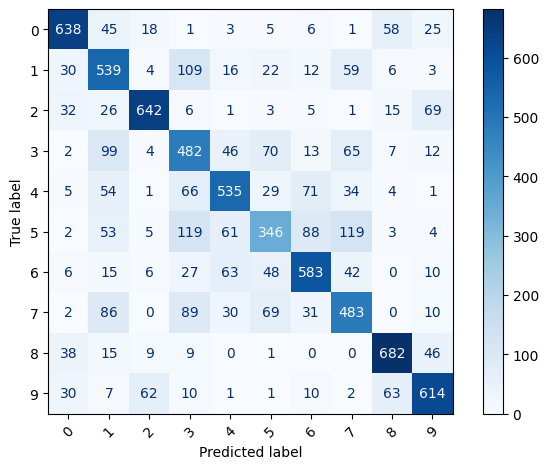

array([[638,  45,  18,   1,   3,   5,   6,   1,  58,  25],
       [ 30, 539,   4, 109,  16,  22,  12,  59,   6,   3],
       [ 32,  26, 642,   6,   1,   3,   5,   1,  15,  69],
       [  2,  99,   4, 482,  46,  70,  13,  65,   7,  12],
       [  5,  54,   1,  66, 535,  29,  71,  34,   4,   1],
       [  2,  53,   5, 119,  61, 346,  88, 119,   3,   4],
       [  6,  15,   6,  27,  63,  48, 583,  42,   0,  10],
       [  2,  86,   0,  89,  30,  69,  31, 483,   0,  10],
       [ 38,  15,   9,   9,   0,   1,   0,   0, 682,  46],
       [ 30,   7,  62,  10,   1,   1,  10,   2,  63, 614]])

In [ ]:
test_confusion_matrix(model_pi_4500, test_loader, device)

## Experiment 2: Supervised with 1000 labeled
This is the low-label baseline: same architecture, same augmentations, but no unlabeled loss.


In [ ]:

from torchvision import models

def build_supervised_resnet18(num_classes=10, device="cpu"):
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)


In [ ]:
EPOCHS_SUP_1000 = 30
LR_SUP = 3e-4

model_sup_1000 = build_supervised_resnet18(num_classes=10, device=device)

hist_sup_1000, best_sup_1000 = train_supervised(
    model_sup_1000,
    train_loader=sup_loader_1000,
    val_loader=val_loader,
    device=device,
    epochs=EPOCHS_SUP_1000,
    lr=LR_SUP
)

test_sup_1000 = run_test_eval(model_sup_1000, test_loader, device, tag="SUP-1000")




supervised ep 001 | train loss 2.2838 acc 0.1432 | val loss 2.3253 acc 0.1560 f1m 0.0847 | 2.9s
supervised ep 002 | train loss 1.9139 acc 0.2852 | val loss 2.1133 acc 0.2560 f1m 0.2192 | 2.0s
supervised ep 003 | train loss 1.7161 acc 0.3646 | val loss 1.9848 acc 0.2320 f1m 0.1588 | 2.0s
supervised ep 004 | train loss 1.5495 acc 0.4531 | val loss 1.9130 acc 0.2720 f1m 0.1934 | 2.0s
supervised ep 005 | train loss 1.4434 acc 0.4674 | val loss 2.1084 acc 0.2380 f1m 0.1333 | 2.0s
supervised ep 006 | train loss 1.3502 acc 0.5104 | val loss 2.0660 acc 0.2720 f1m 0.1853 | 2.0s
supervised ep 007 | train loss 1.2699 acc 0.5547 | val loss 1.8346 acc 0.3300 f1m 0.2790 | 2.0s
supervised ep 008 | train loss 1.1895 acc 0.5794 | val loss 1.7625 acc 0.3300 f1m 0.3003 | 2.0s
supervised ep 009 | train loss 1.0668 acc 0.6380 | val loss 1.6680 acc 0.3760 f1m 0.3550 | 2.0s
supervised ep 010 | train loss 1.0009 acc 0.6367 | val loss 1.5806 acc 0.4140 f1m 0.4035 | 2.0s
supervised ep 011 | train loss 0.8731 ac

Confusion matrix:


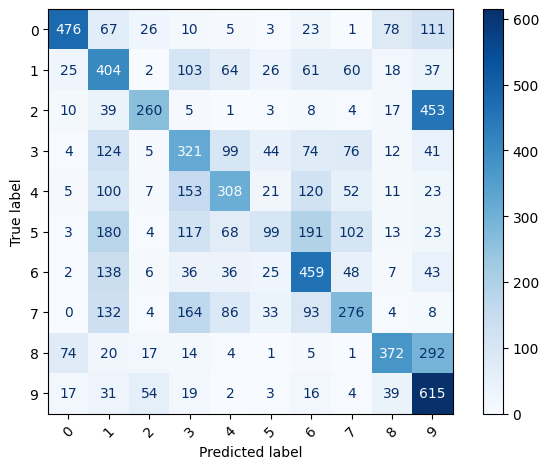

array([[476,  67,  26,  10,   5,   3,  23,   1,  78, 111],
       [ 25, 404,   2, 103,  64,  26,  61,  60,  18,  37],
       [ 10,  39, 260,   5,   1,   3,   8,   4,  17, 453],
       [  4, 124,   5, 321,  99,  44,  74,  76,  12,  41],
       [  5, 100,   7, 153, 308,  21, 120,  52,  11,  23],
       [  3, 180,   4, 117,  68,  99, 191, 102,  13,  23],
       [  2, 138,   6,  36,  36,  25, 459,  48,   7,  43],
       [  0, 132,   4, 164,  86,  33,  93, 276,   4,   8],
       [ 74,  20,  17,  14,   4,   1,   5,   1, 372, 292],
       [ 17,  31,  54,  19,   2,   3,  16,   4,  39, 615]])

In [ ]:
test_confusion_matrix(model_sup_1000, test_loader, device)

## Experiment 3: SimCLR + PI-model with 1000 labeled
This is the main semi-supervised result: low labels + unlabeled consistency.


In [ ]:

model_pi_1000 = build_model(
    simclr_ckpt_path=SIMCLR_CKPT_PATH,
    projection_dim=128,
    num_classes=10,
    device=device,
    freeze_encoder=True,
)

hist_pi_1000, best_pi_1000 = train_pi(
    model_pi_1000,
    labeled_loader=labeled_loader_pi_1000,
    unlabeled_loader=unlabeled_loader,
    val_loader=val_loader,
    device=device,
    epochs=cfg.epochs_pi_1000,
    lr=cfg.lr_head,
    max_w=cfg.pi_max_w,

)

test_pi_1000 = run_test_eval(model_pi_1000, test_loader, device, tag="PI-1000")
best_pi_1000, test_pi_1000


Checkpoint keys: dict_keys(['epoch', 'simclr_state', 'cfg'])

First keys in simclr_state:
  encoder.conv1.weight
  encoder.bn1.weight
  encoder.bn1.bias
  encoder.bn1.running_mean
  encoder.bn1.running_var
  encoder.bn1.num_batches_tracked
  encoder.layer1.0.conv1.weight
  encoder.layer1.0.bn1.weight
  encoder.layer1.0.bn1.bias
  encoder.layer1.0.bn1.running_mean

 encoder loaded into ResNet
 missing: 0
 unexpected: 0
Trainable params: 5,130 / 11,181,642
[PI ] ep 001 | lam 0.577 | loss 2.4230 (sup 2.4229 cons 0.0001) | val loss 2.1026 acc 0.2080 f1m 0.1909 | 3.9s
[PI ] ep 002 | lam 1.457 | loss 1.9785 (sup 1.9783 cons 0.0001) | val loss 1.8068 acc 0.3760 f1m 0.3479 | 3.9s
[PI ] ep 003 | lam 3.251 | loss 1.6971 (sup 1.6966 cons 0.0002) | val loss 1.5848 acc 0.4640 f1m 0.4399 | 3.8s
[PI ] ep 004 | lam 6.411 | loss 1.4874 (sup 1.4860 cons 0.0002) | val loss 1.4146 acc 0.5300 f1m 0.5208 | 3.8s
[PI ] ep 005 | lam 11.173 | loss 1.3462 (sup 1.3433 cons 0.0003) | val loss 1.2985 acc 0.5660 f1m

({'epoch': 27,
  'lambda_u': 30.0,
  'train_loss': 0.7913660804430643,
  'train_sup': 0.7678497632344564,
  'train_cons': 0.0007838778547011316,
  'val_loss': 1.0072968683242798,
  'val_acc': 0.67,
  'val_f1_macro': 0.67198806518309,
  'sec': 3.817556142807007},
 {'loss': 0.9656902713775635, 'acc': 0.654, 'f1_macro': 0.6542797735876562})

Confusion matrix:


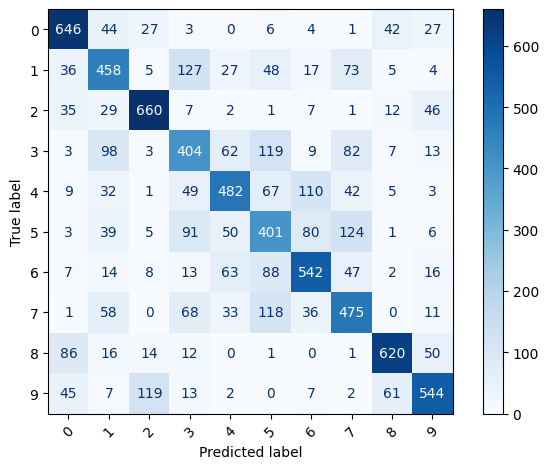

array([[646,  44,  27,   3,   0,   6,   4,   1,  42,  27],
       [ 36, 458,   5, 127,  27,  48,  17,  73,   5,   4],
       [ 35,  29, 660,   7,   2,   1,   7,   1,  12,  46],
       [  3,  98,   3, 404,  62, 119,   9,  82,   7,  13],
       [  9,  32,   1,  49, 482,  67, 110,  42,   5,   3],
       [  3,  39,   5,  91,  50, 401,  80, 124,   1,   6],
       [  7,  14,   8,  13,  63,  88, 542,  47,   2,  16],
       [  1,  58,   0,  68,  33, 118,  36, 475,   0,  11],
       [ 86,  16,  14,  12,   0,   1,   0,   1, 620,  50],
       [ 45,   7, 119,  13,   2,   0,   7,   2,  61, 544]])

In [ ]:
test_confusion_matrix(model_pi_1000, test_loader, device)

## Experiment 4: Supervised with 4500 labeled

In [ ]:
EPOCHS_SUP_4500 = 30
LR_SUP = 3e-4

model_sup_4500 = build_supervised_resnet18(num_classes=10, device=device)

hist_sup_4500, best_sup_4500 = train_supervised(
    model_sup_4500,
    train_loader=sup_loader_4500,
    val_loader=val_loader,
    device=device,
    epochs=EPOCHS_SUP_1000,
    lr=LR_SUP
)

test_sup_4500 = run_test_eval(model_sup_4500, test_loader, device, tag="SUP-4500")




supervised ep 001 | train loss 1.8546 acc 0.3116 | val loss 1.7221 acc 0.3060 f1m 0.2582 | 6.2s
supervised ep 002 | train loss 1.4483 acc 0.4575 | val loss 1.4236 acc 0.4660 f1m 0.4456 | 6.2s
supervised ep 003 | train loss 1.2677 acc 0.5273 | val loss 1.4081 acc 0.4900 f1m 0.4682 | 6.2s
supervised ep 004 | train loss 1.1257 acc 0.5843 | val loss 1.2775 acc 0.5460 f1m 0.5222 | 6.1s
supervised ep 005 | train loss 0.9961 acc 0.6340 | val loss 1.3172 acc 0.5380 f1m 0.5241 | 6.2s
supervised ep 006 | train loss 0.9186 acc 0.6769 | val loss 1.3058 acc 0.5260 f1m 0.5204 | 6.1s
supervised ep 007 | train loss 0.8081 acc 0.7098 | val loss 1.2309 acc 0.5480 f1m 0.5456 | 6.2s
supervised ep 008 | train loss 0.7234 acc 0.7420 | val loss 1.3167 acc 0.5520 f1m 0.5486 | 6.1s
supervised ep 009 | train loss 0.6487 acc 0.7730 | val loss 1.4632 acc 0.5380 f1m 0.5291 | 6.1s
supervised ep 010 | train loss 0.6064 acc 0.7849 | val loss 1.2630 acc 0.5700 f1m 0.5666 | 6.2s
supervised ep 011 | train loss 0.5517 ac

Confusion matrix:


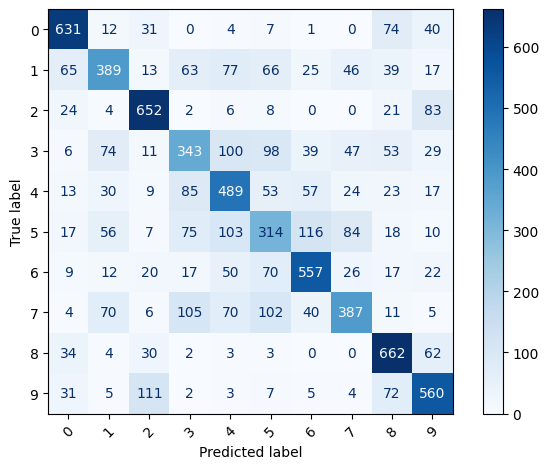

array([[631,  12,  31,   0,   4,   7,   1,   0,  74,  40],
       [ 65, 389,  13,  63,  77,  66,  25,  46,  39,  17],
       [ 24,   4, 652,   2,   6,   8,   0,   0,  21,  83],
       [  6,  74,  11, 343, 100,  98,  39,  47,  53,  29],
       [ 13,  30,   9,  85, 489,  53,  57,  24,  23,  17],
       [ 17,  56,   7,  75, 103, 314, 116,  84,  18,  10],
       [  9,  12,  20,  17,  50,  70, 557,  26,  17,  22],
       [  4,  70,   6, 105,  70, 102,  40, 387,  11,   5],
       [ 34,   4,  30,   2,   3,   3,   0,   0, 662,  62],
       [ 31,   5, 111,   2,   3,   7,   5,   4,  72, 560]])

In [ ]:
test_confusion_matrix(model_sup_4500, test_loader, device)

In [ ]:

import pandas as pd

summary = pd.DataFrame([
    {"run": "PI-4500", "best_val_acc": best_pi_4500["val_acc"], "best_val_f1_macro": best_pi_4500.get("val_f1_macro", None), "test_acc": test_pi_4500["acc"], "test_f1_macro": test_pi_4500.get("f1_macro", None)},
    {"run": "SUP-1000", "best_val_acc": best_sup_1000["val_acc"], "best_val_f1_macro": best_sup_1000.get("val_f1_macro", None), "test_acc": test_sup_1000["acc"], "test_f1_macro": test_sup_1000.get("f1_macro", None)},
    {"run": "PI-1000", "best_val_acc": best_pi_1000["val_acc"], "best_val_f1_macro": best_pi_1000.get("val_f1_macro", None), "test_acc": test_pi_1000["acc"], "test_f1_macro": test_pi_1000.get("f1_macro", None)},
]).sort_values("run")

summary


In [ ]:

import matplotlib.pyplot as plt

def plot_curves(hist, title):
    df = pd.DataFrame(hist)
    plt.figure()
    plt.plot(df["epoch"], df["val_acc"])
    plt.xlabel("epoch")
    plt.ylabel("val_acc")
    plt.title(title)
    plt.show()

plot_curves(hist_pi_4500, "PI-4500: val_acc")
plot_curves(hist_sup_1000, "SUP-1000: val_acc")
plot_curves(hist_pi_1000, "PI-1000: val_acc")


## Experiment 5: PI-model with 1000 labeled

In [ ]:
def train_pi_from_scratch_1000(
    epochs=30,
    lr=3e-4,
    weight_decay=1e-4,
    max_w=20.0,
    rampup_frac=0.3,
    print_every=1,
):
    model = build_supervised_resnet18(num_classes=10, device=device)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    ce = nn.CrossEntropyLoss()

    rampup_epochs = int(rampup_frac * epochs)

    best = {"val_acc": -1.0, "epoch": 0, "state": None, "val": None}

    for ep in range(1, epochs + 1):
        model.train()

        lam = rampup_weight(ep - 1, rampup_epochs, max_w)  # ep-1 so epoch1 is near 0
        running = 0.0
        running_sup = 0.0
        running_cons = 0.0
        seen = 0

        unl_it = iter(unlabeled_loader)

        for (x1, x2, y) in labeled_loader_pi_1000:
            try:
                u1, u2, _ = next(unl_it)
            except StopIteration:
                unl_it = iter(unlabeled_loader)
                u1, u2, _ = next(unl_it)

            x1 = x1.to(device, non_blocking=True)
            x2 = x2.to(device, non_blocking=True)
            y  = y.to(device, non_blocking=True)

            u1 = u1.to(device, non_blocking=True)
            u2 = u2.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)

            # supervised loss
            logits_x1 = model(x1)
            sup_loss = ce(logits_x1, y)

            # consistency loss
            logits_u1 = model(u1)
            logits_u2 = model(u2)
            cons_loss = consistency_mse(logits_u1, logits_u2)

            loss = sup_loss + lam * cons_loss
            loss.backward()
            opt.step()

            bs = x1.size(0)
            running += loss.item() * bs
            running_sup += sup_loss.item() * bs
            running_cons += cons_loss.item() * bs
            seen += bs

        train_loss = running / seen
        train_sup  = running_sup / seen
        train_cons = running_cons / seen

        val = evaluate(model, val_loader, device)

        if val["acc"] > best["val_acc"]:
            best["val_acc"] = val["acc"]
            best["epoch"] = ep
            best["val"] = val


        if ep % print_every == 0:
            print(f"PI-1000 ep {ep:03d} | lam {lam:.3f} | loss {train_loss:.4f} (sup {train_sup:.4f} cons {train_cons:.4f})"
                  f" | val loss {val['loss']:.4f} acc {val['acc']:.4f} f1m {val['f1_macro']:.4f}")


    test = evaluate(model, test_loader, device)
    print(f"[PI-SCRATCH-1000] BEST val@ep {best['epoch']:03d}: acc {best['val']['acc']:.4f} f1m {best['val']['f1_macro']:.4f}")
    print(f"[PI-SCRATCH-1000] TEST: loss {test['loss']:.4f} acc {test['acc']:.4f} f1m {test['f1_macro']:.4f}")

    return model, best, test


model_pi_scratch_1000, best_pi_scratch_1000, test_pi_scratch_1000 = train_pi_from_scratch_1000(
    epochs=30,
    lr=3e-4,
    weight_decay=1e-4,
    max_w=20.0,
    rampup_frac=0.3
)

PI-1000 ep 001 | lam 0.135 | loss 2.2391 (sup 2.2390 cons 0.0008) | val loss 2.2103 acc 0.1840 f1m 0.1557
PI-1000 ep 002 | lam 0.385 | loss 1.8688 (sup 1.8682 cons 0.0015) | val loss 2.0816 acc 0.2460 f1m 0.1534
PI-1000 ep 003 | lam 0.971 | loss 1.7358 (sup 1.7333 cons 0.0026) | val loss 1.8298 acc 0.3160 f1m 0.2781
PI-1000 ep 004 | lam 2.167 | loss 1.5512 (sup 1.5456 cons 0.0026) | val loss 1.6125 acc 0.3880 f1m 0.3694
PI-1000 ep 005 | lam 4.274 | loss 1.4512 (sup 1.4362 cons 0.0035) | val loss 1.6493 acc 0.3620 f1m 0.3498
PI-1000 ep 006 | lam 7.449 | loss 1.3694 (sup 1.3396 cons 0.0040) | val loss 1.6085 acc 0.3840 f1m 0.3648
PI-1000 ep 007 | lam 11.475 | loss 1.2772 (sup 1.2285 cons 0.0042) | val loss 1.6825 acc 0.3900 f1m 0.3717
PI-1000 ep 008 | lam 15.624 | loss 1.2787 (sup 1.2077 cons 0.0045) | val loss 1.5311 acc 0.4360 f1m 0.4257
PI-1000 ep 009 | lam 18.803 | loss 1.2155 (sup 1.1154 cons 0.0053) | val loss 1.5227 acc 0.4480 f1m 0.4335
PI-1000 ep 010 | lam 20.000 | loss 1.1239 (

Confusion matrix:


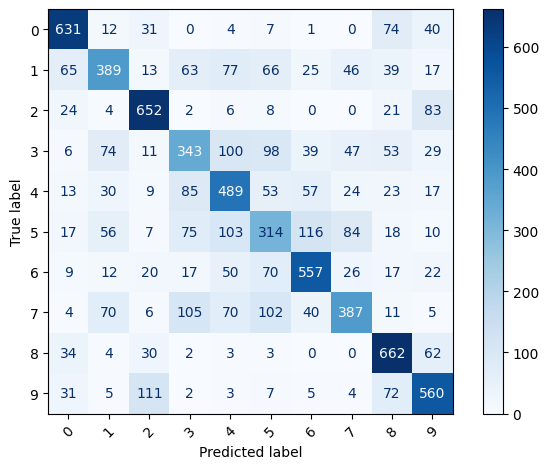

array([[631,  12,  31,   0,   4,   7,   1,   0,  74,  40],
       [ 65, 389,  13,  63,  77,  66,  25,  46,  39,  17],
       [ 24,   4, 652,   2,   6,   8,   0,   0,  21,  83],
       [  6,  74,  11, 343, 100,  98,  39,  47,  53,  29],
       [ 13,  30,   9,  85, 489,  53,  57,  24,  23,  17],
       [ 17,  56,   7,  75, 103, 314, 116,  84,  18,  10],
       [  9,  12,  20,  17,  50,  70, 557,  26,  17,  22],
       [  4,  70,   6, 105,  70, 102,  40, 387,  11,   5],
       [ 34,   4,  30,   2,   3,   3,   0,   0, 662,  62],
       [ 31,   5, 111,   2,   3,   7,   5,   4,  72, 560]])

In [ ]:
test_confusion_matrix(model_pi_scratch_1000, test_loader, device)

## Experiment 5: PI-model with 4500 labeled

In [ ]:
def train_pi_from_scratch_4500(
    epochs=30,
    lr=3e-4,
    weight_decay=1e-4,
    max_w=20.0,
    rampup_frac=0.3,
    print_every=1,
):
    model = build_supervised_resnet18(num_classes=10, device=device)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    ce = nn.CrossEntropyLoss()

    rampup_epochs = int(rampup_frac * epochs)

    best = {"val_acc": -1.0, "epoch": 0, "state": None, "val": None}

    for ep in range(1, epochs + 1):
        model.train()

        lam = rampup_weight(ep - 1, rampup_epochs, max_w)  # ep-1 so epoch1 is near 0
        running = 0.0
        running_sup = 0.0
        running_cons = 0.0
        seen = 0

        unl_it = iter(unlabeled_loader)

        for (x1, x2, y) in labeled_loader_pi_4500:
            try:
                u1, u2, _ = next(unl_it)
            except StopIteration:
                unl_it = iter(unlabeled_loader)
                u1, u2, _ = next(unl_it)

            x1 = x1.to(device, non_blocking=True)
            x2 = x2.to(device, non_blocking=True)
            y  = y.to(device, non_blocking=True)

            u1 = u1.to(device, non_blocking=True)
            u2 = u2.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)

            # supervised loss
            logits_x1 = model(x1)
            sup_loss = ce(logits_x1, y)

            # consistency loss
            logits_u1 = model(u1)
            logits_u2 = model(u2)
            cons_loss = consistency_mse(logits_u1, logits_u2)

            loss = sup_loss + lam * cons_loss
            loss.backward()
            opt.step()

            bs = x1.size(0)
            running += loss.item() * bs
            running_sup += sup_loss.item() * bs
            running_cons += cons_loss.item() * bs
            seen += bs

        train_loss = running / seen
        train_sup  = running_sup / seen
        train_cons = running_cons / seen

        val = evaluate(model, val_loader, device)

        if val["acc"] > best["val_acc"]:
            best["val_acc"] = val["acc"]
            best["epoch"] = ep
            best["val"] = val


        if ep % print_every == 0:
            print(f"PI-4500 ep {ep:03d} | lam {lam:.3f} | loss {train_loss:.4f} (sup {train_sup:.4f} cons {train_cons:.4f})"
                  f" | val loss {val['loss']:.4f} acc {val['acc']:.4f} f1m {val['f1_macro']:.4f}")


    test = evaluate(model, test_loader, device)
    print(f"PI-SCRATCH-4500 BEST val@ep {best['epoch']:03d}: acc {best['val']['acc']:.4f} f1m {best['val']['f1_macro']:.4f}")
    print(f"PI-SCRATCH-4500 TEST: loss {test['loss']:.4f} acc {test['acc']:.4f} f1m {test['f1_macro']:.4f}")

    return model, best, test


model_pi_scratch_4500, best_pi_scratch_4500, test_pi_scratch_4500 = train_pi_from_scratch_4500(
    epochs=30,
    lr=3e-4,
    weight_decay=1e-4,
    max_w=20.0,
    rampup_frac=0.3
)

PI-4500 ep 001 | lam 0.135 | loss 1.8438 (sup 1.8435 cons 0.0019) | val loss 1.6141 acc 0.3700 f1m 0.3260
PI-4500 ep 002 | lam 0.385 | loss 1.4678 (sup 1.4664 cons 0.0038) | val loss 1.4767 acc 0.4500 f1m 0.4366
PI-4500 ep 003 | lam 0.971 | loss 1.2712 (sup 1.2663 cons 0.0051) | val loss 1.4000 acc 0.5000 f1m 0.4831
PI-4500 ep 004 | lam 2.167 | loss 1.1449 (sup 1.1306 cons 0.0066) | val loss 1.2970 acc 0.5420 f1m 0.5267
PI-4500 ep 005 | lam 4.274 | loss 1.0761 (sup 1.0453 cons 0.0072) | val loss 1.2847 acc 0.5240 f1m 0.5177
PI-4500 ep 006 | lam 7.449 | loss 0.9989 (sup 0.9437 cons 0.0074) | val loss 1.2997 acc 0.5320 f1m 0.5196
PI-4500 ep 007 | lam 11.475 | loss 0.9242 (sup 0.8401 cons 0.0073) | val loss 1.2224 acc 0.5540 f1m 0.5418
PI-4500 ep 008 | lam 15.624 | loss 0.8816 (sup 0.7672 cons 0.0073) | val loss 1.1344 acc 0.5640 f1m 0.5664
PI-4500 ep 009 | lam 18.803 | loss 0.8378 (sup 0.7099 cons 0.0068) | val loss 1.1348 acc 0.5840 f1m 0.5776
PI-4500 ep 010 | lam 20.000 | loss 0.7846 (

Confusion matrix:


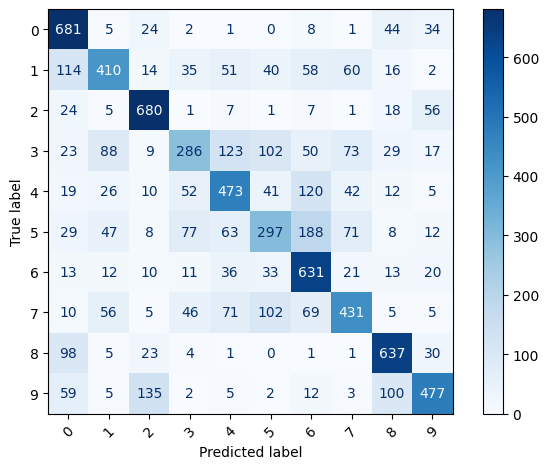

array([[681,   5,  24,   2,   1,   0,   8,   1,  44,  34],
       [114, 410,  14,  35,  51,  40,  58,  60,  16,   2],
       [ 24,   5, 680,   1,   7,   1,   7,   1,  18,  56],
       [ 23,  88,   9, 286, 123, 102,  50,  73,  29,  17],
       [ 19,  26,  10,  52, 473,  41, 120,  42,  12,   5],
       [ 29,  47,   8,  77,  63, 297, 188,  71,   8,  12],
       [ 13,  12,  10,  11,  36,  33, 631,  21,  13,  20],
       [ 10,  56,   5,  46,  71, 102,  69, 431,   5,   5],
       [ 98,   5,  23,   4,   1,   0,   1,   1, 637,  30],
       [ 59,   5, 135,   2,   5,   2,  12,   3, 100, 477]])

In [ ]:
test_confusion_matrix(model_pi_scratch_4500, test_loader, device)